## 5.1 one simple example

In [5]:
import gzip
import struct
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        # 读取文件头信息
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        # 从文件中读取数据
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    return data


def shape_data(images, labels):
    # 调整图像数据形状，使其符合模型要求
    images_flattened = images.reshape(images.shape[0], -1)

    return list(zip(images_flattened, labels))

def encode_label(num):
    vector = np.zeros((10, 1))
    vector[num] = 1
    return vector

def average_digit(data, digit):
    filtered_data = [x[0] for x in data if x[1] == digit]
    filtered_array = np.asarray(filtered_data)
    return np.average(filtered_array, axis=0)
    
def sigmoid_double(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid(x):
    return np.vectorize(sigmoid_double)(x)

def predict(W, x, a, b):
    # print(np.dot(W, x)/a)
    return sigmoid(np.dot(W, x)/a + b)

def evaluate(average_image, digit, data_set, threshold=0.9):
    W = np.transpose(average_image)

    visit = 0
    win = 0
    for data, label in tqdm(data_set):
        predict_sigmoid = predict(W, data, 1e5, -30)

        if (predict_sigmoid > threshold) and (label == digit):
            win += 1
        elif (predict_sigmoid <= threshold) and (label != digit):
            win += 1

        visit += 1

    return win/visit

In [9]:
# 使用示例
train_images_file = r'Q:\Project\data\train-images-idx3-ubyte.gz'
train_labels_file = r'Q:\Project\data\train-labels-idx1-ubyte.gz'
test_images_file = r'Q:\Project\data\t10k-images-idx3-ubyte.gz'
test_labels_file = r'Q:\Project\data\t10k-labels-idx1-ubyte.gz'

train_images = read_idx(train_images_file)
train_labels = read_idx(train_labels_file)
test_images = read_idx(test_images_file)
test_labels = read_idx(test_labels_file)

print(f"Number of training images: {train_images.shape[0]}")
print(f"Training image size: {train_images.shape[1]}x{train_images.shape[2]}")
print(f"Number of training labels: {train_labels.shape[0]}")

print(f"Number of test images: {test_images.shape[0]}")
print(f"Test image size: {test_images.shape[1]}x{test_images.shape[2]}")
print(f"Number of test labels: {test_labels.shape[0]}")


Number of training images: 60000
Training image size: 28x28
Number of training labels: 60000
Number of test images: 10000
Test image size: 28x28
Number of test labels: 10000


In [91]:
train_data = shape_data(train_images, train_labels)
test_data = shape_data(test_images, test_labels)

len(train_data)

60000

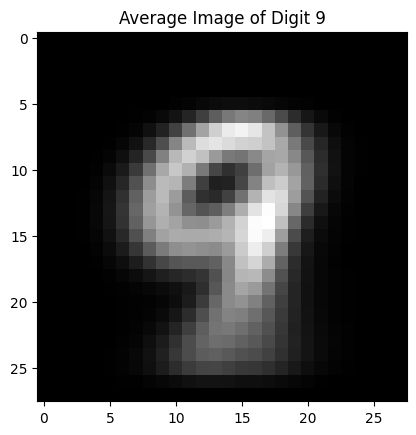

In [88]:
average_num = 9
average_image = average_digit(train_data, average_num)

# 查看结果
plt.imshow(average_image.reshape(28, 28), cmap='gray')
plt.title(f"Average Image of Digit {average_num}")
plt.show()


In [93]:
result = evaluate(average_image, 9, train_data)
print()
print(f"{result:.2%}")

result = evaluate(average_image, 9, test_data)
print()
print(f"{result:.2%}")


100%|██████████| 60000/60000 [00:01<00:00, 30955.81it/s]



84.47%


100%|██████████| 10000/10000 [00:00<00:00, 28360.57it/s]


83.87%


In [101]:
nine_test = [(data,label) for data, label in test_data if label == 9]

In [103]:
result = evaluate(average_image, 9, nine_test)
print()
print(f"{result:.2%}")

100%|██████████| 1009/1009 [00:00<00:00, 26178.40it/s]


28.74%


In [105]:
W = np.zeros((10, 784))

for average_num in range(10):
    average_image = average_digit(train_data, average_num)
    W[average_num] = average_image

In [110]:
def evaluate_whole(W, data_set):
    visit = 0
    win = 0
    for data, label in tqdm(data_set):
        predict_sigmoid = predict(W, data, 1e5, -30)
        max_index = np.argmax(predict_sigmoid)

        if max_index == label:
            win += 1

        visit += 1

    return win/visit

In [111]:
evaluate_whole(W, train_data)

100%|██████████| 60000/60000 [00:02<00:00, 21751.70it/s]


0.6233333333333333

## NN

In [2]:
import numpy as np
import numpy.random as nr
import scipy.special as sp
from mnist import MNIST
from CelestialVault.instances import NeuralNetwork, ActivationLayer, DenseLayer, SequentialNetwork

In [12]:
# 加载MNIST数据
mndata = MNIST(r'mnist')
images, labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

# 创建神经网络实例
input_nodes = 784
hidden_nodes = 100
output_nodes = 10
learning_rate = 0.1

n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# 训练神经网络
epochs = 5
for e in range(epochs):
    for i in range(len(images)):
        # 归一化输入值
        inputs = np.asfarray(images[i]) / 255.0 * 0.99 + 0.01
        # 创建目标输出值（全0.01，目标标签位置为0.99）
        targets = np.zeros(output_nodes) + 0.01
        targets[labels[i]] = 0.99
        n.train(inputs, targets)

# 测试神经网络
scorecard = []
for i in range(len(test_images)):
    # 归一化测试图像
    inputs = np.asfarray(test_images[i]) / 255.0 * 0.99 + 0.01
    # 查询网络的输出
    correct_label = test_labels[i]
    predicted_label = n.query(inputs)
    if predicted_label == correct_label:
        scorecard.append(1)
    else:
        scorecard.append(0)

# 计算准确率
scorecard_array = np.asarray(scorecard)
print(f'性能 = {scorecard_array.sum() / scorecard_array.size}')

性能 = 0.9669


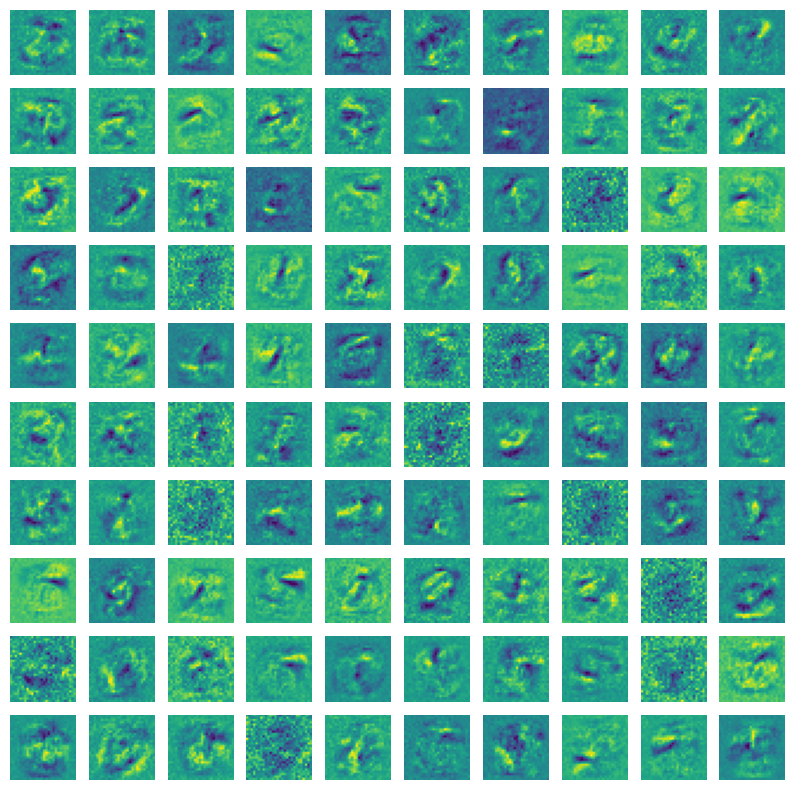

In [14]:
import matplotlib.pyplot as plt

# 假设我们有一个训练好的神经网络实例 n
# 可视化输入层到隐藏层的权重
def visualize_wih_weights(network):
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            ax = axes[i, j]
            weight_matrix = network.wih[i*10+j].reshape(28, 28)
            ax.imshow(weight_matrix, cmap='viridis')
            ax.axis('off')
    plt.show()

# 可视化隐藏层到输出层的权重
def visualize_who_weights(network):
    fig, axes = plt.subplots(1, network.onodes, figsize=(15, 2))
    for i in range(network.onodes):
        ax = axes[i]
        weight_matrix = network.who[i].reshape(10, 10)  # 假设隐藏层有100个节点
        ax.imshow(weight_matrix, cmap='viridis')
        ax.axis('off')
    plt.show()

visualize_wih_weights(n)


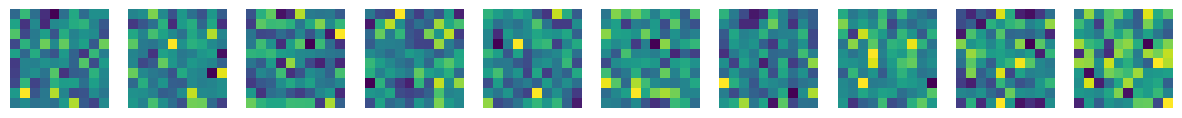

In [15]:
# 调用可视化函数
visualize_who_weights(n)